In [1]:
import warnings
warnings.filterwarnings("ignore")
import bo_wrangle as wra
import wrangle as w

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression


In [2]:
def transform_intake_condition(df):
    """
    Transforms the intake_condition column of a DataFrame by performing several operations.

    Args:
        df (pandas.DataFrame): The input DataFrame containing an 'intake_condition' column.

    Returns:
        pandas.DataFrame: The transformed DataFrame.

    """

    df = df.apply(lambda x: x.astype(str).str.lower())

    # Change 'Feral', 'Neurologic', 'Behavior', 'Space' to 'mental' category
    df['intake_condition'] = df['intake_condition'].replace(['feral', 'neurologic', 'behavior', 'space'], 'mental')

    # Set values indicating medical attention
    df['intake_condition'] = df['intake_condition'].replace(['nursing', 'neonatal', 'medical', 'pregnant', 'med attn', 
                                                            'med urgent', 'parvo', 'agonal', 'panleuk'], 'medical attention')

    # Drop rows with 'other', 'unknown', and 'nan' values
    df = df[df['intake_condition'].isin(['other', 'unknown', 'nan']) == False]

    return df

def transform_color(df):
    """
    Transforms the color column of a DataFrame by performing several operations.

    Args:
        df (pandas.DataFrame): The input DataFrame containing a 'color' column.

    Returns:
        pandas.DataFrame: The transformed DataFrame with additional columns.

    """

    # lowercase everything
    df = df.apply(lambda x: x.astype(str).str.lower())

    # Add spaces between color names separated by slashes
    df['color'] = df['color'].str.replace('/', ' / ')

    # Replace color names with their corresponding standard names
    replacements = {
        'chocolate': 'brown',
        'liver': 'brown',
        'ruddy': 'brown',
        'apricot': 'orange',
        'pink': 'red',
        'cream': 'white',
        'flame point': 'white',
        'blue': 'gray',
        'silver': 'gray',
        'yellow': 'gold',
        'torbie': 'tricolor',
        'tortie': 'tricolor',
        'calico': 'tricolor'
    }
    df['color'] = df['color'].replace(replacements, regex=True)

    # Create new column 'primary_color' with the first color
    colors = ['black', 'brown', 'white', 'tan', 'brindle', 'gray', 'fawn', 'red', 'sable', 'buff', 'orange', 'blue',
              'tricolor', 'gold', 'cream', 'lynx point', 'seal point', 'agouti', 'lilac point']
    for color in colors:
        df.loc[df['color'].str.startswith(color), 'primary_color'] = color

    # Drop rows with 'unknown' color
    df = df[df['color'] != 'unknown']

    # Create column indicating if the animal has a tabby pattern
    df['is_tabby'] = df['color'].str.contains('tabby').astype(int)

    # Create column indicating if the animal has mixed colors
    df["mix_color"] = np.where(df['color'].str.contains(r'\/|tricolor|torbie|tortie'), 1, 0)

    df = df.drop(columns=["color"])

    return df

def get_prep_aa(df):
    # made all column names lower case
    df.columns = df.columns.str.lower()
    df = df.apply(lambda x: x.astype(str).str.lower())
    new_columns = {
        'datetime_x': 'outcome_datetime',
        'datetime_y': 'intake_datetime',
        'monthyear_x': 'outcome_monthyear',
        'monthyear_y': 'intake_monthyear',
        'name_y': 'name',
        'breed_y': 'breed',
        'animal type_y': 'species',
        'outcome type': 'outcome',
        'color_y': 'color',
        'sex upon outcome': 'outcome_sex',
        'sex upon intake': 'intake_sex',
        'intake type': 'intake_type',
        'age upon intake': 'intake_age',
        'age upon outcome': 'outcome_age',
        'date of birth': 'dob',
        'intake condition': 'intake_condition',
        'found location': 'found_location',
        'animal id': 'id'      
    }
    df = df.rename(columns=new_columns)
    #dropped unnecessary column names, outcome subtype, due to having over 119k of 193k rows empty, intake_monthyear, outcome_month_year, animal type_x, are predominantly the same, 
    columns_to_drop = ['outcome subtype', 'name_x', 'breed_x', 'animal type_x', 'color_x', 'intake_monthyear', 'outcome_monthyear']
    df = df.drop(columns=columns_to_drop)

    # dropping nulls
    df.dropna(subset=['intake_sex'], inplace=True)
    df.dropna(subset=['outcome'], inplace=True)

    # create dates
    df['outcome_date'] = pd.to_datetime(df['outcome_datetime']).dt.strftime('%m/%d/%Y').astype("datetime64")
    df['intake_date'] = pd.to_datetime(df['intake_datetime']).dt.strftime('%m/%d/%Y').astype("datetime64")
    df['dob'] = pd.to_datetime(df['dob'], format='%m/%d/%Y')

    # create ages
    df['intake_age'] = (df.intake_date - df.dob).dt.days
    df['outcome_age'] = (df.outcome_date - df.dob).dt.days

    # days in center
    df["tenure_days"] = (df['outcome_age'] - df['intake_age'] )
    # filter weird dates
    df = df[df.tenure_days > 0]
    
    df['tenure_days'] = df.tenure_days.astype(float)

    # color and intake condition columns
    df = transform_color(df)
    df = transform_intake_condition(df)

    #filtered for cats and dogs
    df = df[df['species'].isin(['cat', 'dog'])]
    df = df[df['outcome'].isin(['adoption', 'transfer', 'rto-adopt', 'return to owner', 'euthanasia'])]
    df = df[df['intake_type'].isin(['stray', 'owner surrender', 'public assist', 'abandoned'])]

    # mix breeds columns
    df['mix_breeds'] = np.where(df['breed'].str.contains('mix', case=False, na=False), 1, 0)
    df['two_breeds'] = np.where(df['breed'].str.contains('/', case=False, na=False), 1, 0)
    df['pure_breed'] = np.where((df['mix_breeds'] == 0) & (df['two_breeds'] == 0), 1, 0)

    df['mix_breeds'] = np.where(df['breed'].str.contains('mix', case=False, na=False), 'mix_breeds', '')
    df['two_breeds'] = np.where(df['breed'].str.contains('/', case=False, na=False), 'two_breeds', '')
    df['pure_breed'] = np.where((~df['breed'].str.contains('mix', case=False, na=False)) & (~df['breed'].str.contains('/', case=False, na=False)), 'pure_breed', '')

    df['breed_category'] = df[['mix_breeds', 'two_breeds', 'pure_breed']].apply(lambda x: ', '.join(x), axis=1).str.strip(', ')
    
    # if pet has a name 1, if not 0 place in column has_name
    df['has_name'] = np.where(df['name'] != 'nan', 1, 0)

    # dropping unknown sex from df
    df = df[(df.intake_sex != 'unknown') & (df.intake_sex != 'nan')]
    
    # update data type
    df.outcome_age = df.outcome_age.astype('int')
    
    # Define the conditions for each age category
    conditions = [
        (df['outcome_age'] <= 730),
        (df['outcome_age'] >= 731) & (df['outcome_age'] <= 2920),
        (df['outcome_age'] >= 2921)
    ]
    # Define the corresponding values for each age category
    values = ['puppy', 'adult', 'senior']
    # Create the 'age_category' column based on the conditions and values
    df['age_category'] = pd.np.select(conditions, values, default='unknown')
    
    # keep these columns
    keep_col= ['has_name', 'outcome', 'dob', 'age_category',
               'species', 'intake_type', 'intake_condition',
               'intake_date', 'outcome_date', 'intake_age',
               'outcome_age', 'tenure_days', 'intake_sex',
               'breed', 'breed_category', 'mix_breeds', 'two_breeds', 'pure_breed',
               'primary_color', 'is_tabby', 'mix_color']
    df = df[keep_col]
    
    dummies_df = pd.get_dummies(df, columns=[ 'outcome', 'species', 'intake_type',
                                             'intake_condition', 'intake_sex', 'primary_color', 'age_category'])
    model_df = dummies_df.drop(columns=['dob', 'intake_date', 'outcome_date'])
    return df, model_df

    return df

In [5]:
df, model_df = get_prep_aa(df)

In [6]:
model_df.sample(50)

,has_name,intake_age,outcome_age,tenure_days,breed,breed_category,mix_breeds,two_breeds,pure_breed,is_tabby,...,primary_color_orange,primary_color_red,primary_color_sable,primary_color_seal point,primary_color_tan,primary_color_tricolor,primary_color_white,age_category_adult,age_category_puppy,age_category_senior
168694,0,37.0,52,15.0,domestic shorthair mix,mix_breeds,mix_breeds,,,1,...,0,0,0,0,0,0,0,0,1,0
153967,1,2556.0,2569,13.0,whippet mix,mix_breeds,mix_breeds,,,0,...,0,0,0,0,0,0,0,1,0,0
60783,1,51.0,66,15.0,domestic shorthair mix,mix_breeds,mix_breeds,,,1,...,0,0,0,0,0,0,0,0,1,0
89172,1,731.0,1113,382.0,pit bull mix,mix_breeds,mix_breeds,,,0,...,0,0,0,0,0,0,0,1,0,0
159916,1,53.0,55,2.0,domestic shorthair mix,mix_breeds,mix_breeds,,,1,...,0,0,0,0,0,0,0,0,1,0
60720,1,45.0,239,194.0,domestic shorthair mix,mix_breeds,mix_breeds,,,0,...,0,0,0,0,0,0,0,0,1,0
132549,1,3106.0,3115,9.0,domestic medium hair mix,mix_breeds,mix_breeds,,,1,...,0,0,0,0,0,0,0,0,0,1
141635,1,1096.0,1103,7.0,domestic shorthair mix,mix_breeds,mix_breeds,,,1,...,0,0,0,0,0,0,0,1,0,0
164960,1,41.0,75,34.0,domestic medium hair,pure_breed,,,pure_breed,1,...,0,0,0,0,0,0,0,0,1,0
159580,1,153.0,157,4.0,dachshund/labrador retriever,two_breeds,,two_breeds,,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144627 entries, 0 to 197203
Data columns (total 51 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   has_name                            144627 non-null  int64 
 1   intake_age                          144627 non-null  object
 2   outcome_age                         144627 non-null  int64 
 3   tenure_days                         144627 non-null  object
 4   breed                               144627 non-null  object
 5   breed_category                      144627 non-null  object
 6   mix_breeds                          144627 non-null  object
 7   two_breeds                          144627 non-null  object
 8   pure_breed                          144627 non-null  object
 9   is_tabby                            144627 non-null  object
 10  mix_color                           144627 non-null  object
 11  outcome_adoption                    144

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144627 entries, 0 to 197203
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   has_name          144627 non-null  int64 
 1   outcome           144627 non-null  object
 2   dob               144627 non-null  object
 3   age_category      144627 non-null  object
 4   species           144627 non-null  object
 5   intake_type       144627 non-null  object
 6   intake_condition  144627 non-null  object
 7   intake_date       144627 non-null  object
 8   outcome_date      144627 non-null  object
 9   intake_age        144627 non-null  object
 10  outcome_age       144627 non-null  int64 
 11  tenure_days       144627 non-null  object
 12  intake_sex        144627 non-null  object
 13  breed             144627 non-null  object
 14  mix_breeds        144627 non-null  int64 
 15  two_breeds        144627 non-null  int64 
 16  pure_breed        144627 non-null  int

# Acquire

In [3]:
merged_data = w.left_join_csv('austin_animal_outcomes.csv', 'austin_animal_intakes.csv', 'merged_data.csv')

In [4]:
df = merged_data

# Prepare

In [4]:
df, model_df = w.get_prep_aa(df)

In [5]:
df.head() 

,has_name,outcome,dob,age_category,species,intake_type,intake_condition,intake_date,outcome_date,intake_age,outcome_age,tenure_days,intake_sex,breed,mix_breeds,two_breeds,pure_breed,primary_color,is_tabby,mix_color
0,1,rto-adopt,2017-05-02,adult,cat,owner surrender,normal,2019-05-02,2019-05-08,730.0,736,6.0,neutered male,domestic shorthair mix,1,0,0,brown,1,1
1,1,adoption,2017-07-12,puppy,dog,stray,normal,2018-07-12,2018-07-18,365.0,371,6.0,intact male,chihuahua shorthair mix,1,0,0,white,0,1
3,1,adoption,2015-10-08,puppy,dog,stray,normal,2016-02-08,2016-02-13,123.0,128,5.0,intact male,anatol shepherd/labrador retriever,0,1,0,buff,0,0
6,1,adoption,2013-03-24,adult,dog,owner surrender,normal,2018-06-13,2020-10-05,1907.0,2752,845.0,spayed female,chihuahua shorthair mix,1,0,0,brown,0,0
8,1,adoption,2018-03-01,adult,dog,owner surrender,normal,2020-03-01,2020-05-06,731.0,797,66.0,neutered male,american foxhound/labrador retriever,0,1,0,white,0,1


In [6]:
model_df.head()

,has_name,intake_age,outcome_age,tenure_days,mix_breeds,two_breeds,pure_breed,is_tabby,mix_color,outcome_euthanasia,...,primary_color_lynx point,primary_color_orange,primary_color_red,primary_color_sable,primary_color_seal point,primary_color_tan,primary_color_tricolor,primary_color_white,age_category_puppy,age_category_senior
0,1,730.0,736,6.0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,365.0,371,6.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,1,123.0,128,5.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,1907.0,2752,845.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,731.0,797,66.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
df.shape

(144627, 20)

In [8]:
model_df.shape

(144627, 42)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144627 entries, 0 to 197203
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   has_name          144627 non-null  int64 
 1   outcome           144627 non-null  object
 2   dob               144627 non-null  object
 3   age_category      144627 non-null  object
 4   species           144627 non-null  object
 5   intake_type       144627 non-null  object
 6   intake_condition  144627 non-null  object
 7   intake_date       144627 non-null  object
 8   outcome_date      144627 non-null  object
 9   intake_age        144627 non-null  object
 10  outcome_age       144627 non-null  int64 
 11  tenure_days       144627 non-null  object
 12  intake_sex        144627 non-null  object
 13  breed             144627 non-null  object
 14  mix_breeds        144627 non-null  int64 
 15  two_breeds        144627 non-null  int64 
 16  pure_breed        144627 non-null  int

In [11]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144627 entries, 0 to 197203
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   has_name                            144627 non-null  int64 
 1   intake_age                          144627 non-null  object
 2   outcome_age                         144627 non-null  int64 
 3   tenure_days                         144627 non-null  object
 4   mix_breeds                          144627 non-null  int64 
 5   two_breeds                          144627 non-null  int64 
 6   pure_breed                          144627 non-null  int64 
 7   is_tabby                            144627 non-null  object
 8   mix_color                           144627 non-null  object
 9   outcome_euthanasia                  144627 non-null  uint8 
 10  outcome_return to owner             144627 non-null  uint8 
 11  outcome_rto-adopt                   144

In [12]:
train, validate, test = w.split_data(df, "outcome")

train -> (86775, 20), 60.0%
validate -> (28926, 20),20.0%
test -> (28926, 20), 20.0%


# Question and Hypothesis Statement

## Does breed affect whether an animal will be adopted?

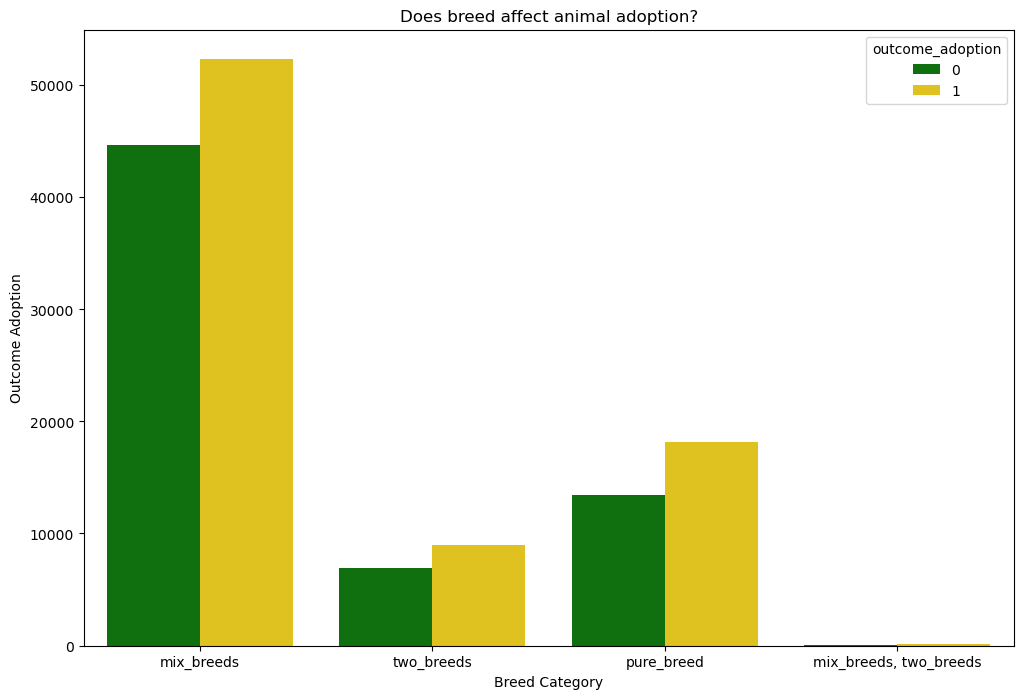

In [8]:
# visualize relationship between cause and visibility
plt.figure(figsize=(12,8))
sns.countplot(x='breed_category', hue='outcome_adoption', data=model_df, palette=['green', 'gold'])
plt.title('Does breed affect animal adoption?')
plt.xlabel('Breed Category')
plt.ylabel('Outcome Adoption')
plt.show()

# Conclusion

# Question and Hypothesis Statement

# Conclusion

# Question and Hypothesis Statement

# Conclusion